In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm  # Correct import for PyMC


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/Project/MMM /messy_synthetic_bed.csv'
df = pd.read_csv(file_path)

# Exploring the Data

In [ ]:
df.head()

,platform,week of,date,campaign name,ad name,audience,impression,clicks,Net+Agency Spend,Bookings (No VTC),Language
0,Snap,12-09-2024,12-14-2024,US|EN|25|E|GUE|Med|GUEBr|CVar|BTL|Soc|SSAU|Sna...,CityLights_15s_Square,1P_AdventureSeekers,18758.0,523.0,57.06,20.0,Spanish
1,META,07-29-2024,07-31-2024,US|EN|25|E|GUE|Med|GUEBr|CVar|BTL|Soc|SSAU|Met...,BeachTime_30s_Vertical,Remkt_PastGuests,74824.0,1426.0,692.28,23.0,Spanish
2,Snap,04-01-2024,04-01-2024,US|EN|25|E|GUE|Med|GUEBr|CVar|BTL|Soc|SSAU|Sna...,IslandBungalow_15s_Square,1P_HolidayShoppers,7755.0,259.0,43.32,23.0,French
3,Google,10-21-2024,10-22-2024,US|EN|24|E|GUE|Med|GUEBr|CGaA|BTL|OLV|SSAU|Goo...,BeachTime_30s_Vertical,Remkt_PastGuests,37147.0,372.0,23.77,90.0,Spanish
4,Snap,10-07-2024,10-13-2024,US|SP|24|E|GUE|Med|GUEBr|CVar|BTL|Soc|SSAU|Sna...,ForestCabin_15s_Landscape,Remkt_PastGuests,39053.0,1638.0,100.89,106.0,Spanish


In [ ]:
# View the shape (rows, columns)
df.shape

(30000, 11)

In [ ]:
# Get info (column data types, non-null counts)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   platform           30000 non-null  object 
 1   week of            30000 non-null  object 
 2   date               30000 non-null  object 
 3   campaign name      30000 non-null  object 
 4   ad name            30000 non-null  object 
 5   audience           30000 non-null  object 
 6   impression         29695 non-null  float64
 7   clicks             29718 non-null  float64
 8   Net+Agency Spend   30000 non-null  object 
 9   Bookings (No VTC)  29698 non-null  float64
 10  Language           30000 non-null  object 
dtypes: float64(3), object(8)
memory usage: 2.5+ MB


In [ ]:
# See basic descriptive stats for numeric columns
df.describe()


,impression,clicks,Bookings (No VTC)
count,29695.000000,29718.000000,29698.000000
mean,52807.176191,1585.542096,149.762913
std,27466.325613,1070.500115,160.826658
min,5000.000000,57.000000,0.000000
25%,29012.000000,725.000000,40.000000
50%,52807.000000,1344.000000,94.000000
75%,76492.000000,2272.000000,200.000000
max,99996.000000,4966.000000,1128.000000


In [ ]:
# Count missing values in each column
df.isna().sum()


,0
platform,0
week of,0
date,0
campaign name,0
ad name,0
audience,0
impression,305
clicks,282
Net+Agency Spend,0
Bookings (No VTC),302


# Checking Data to Clean

In [ ]:
# Replace "NA" or "" with pd.NA (pandas standard for missing)
df = df.replace(["NA", ""], pd.NA)


In [ ]:
# Suppose "Language" is the column with inconsistent casing
df["Language"] = df["Language"].str.title()  # "english" -> "English", "SPANISH" -> "Spanish"


In [ ]:
# For all object (string) columns:
str_cols = df.select_dtypes(include="object").columns
for col in str_cols:
    df[col] = df[col].astype(str).str.strip()


In [ ]:
import re
num_cols = ["impression", "clicks", "Net+Agency Spend", "Bookings (No VTC)"]

for col in num_cols:
    # 1) Remove non-numeric characters (except ".", "-" which might be decimal or sign)
    df[col] = df[col].astype(str).str.replace(r"[^0-9.\-]", "", regex=True)

    # 2) Convert to numeric, invalid => NaN
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [ ]:
actual_cols = df.columns
for weird_name in ["impressionz", "impressi0n", "impr_sions"]:
    if weird_name in actual_cols:
        df.rename(columns={weird_name: "impression"}, inplace=True)


In [ ]:
df.info()
df.head()
df["Language"].value_counts()
df[["week of", "date"]].head()
df[["impression", "clicks", "Net+Agency Spend"]].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   platform           30000 non-null  object 
 1   week of            30000 non-null  object 
 2   date               30000 non-null  object 
 3   campaign name      30000 non-null  object 
 4   ad name            30000 non-null  object 
 5   audience           30000 non-null  object 
 6   impression         29695 non-null  float64
 7   clicks             29718 non-null  float64
 8   Net+Agency Spend   30000 non-null  float64
 9   Bookings (No VTC)  29698 non-null  float64
 10  Language           30000 non-null  object 
dtypes: float64(4), object(7)
memory usage: 2.5+ MB


,impression,clicks,Net+Agency Spend
count,29695.000000,29718.000000,30000.000000
mean,52807.176191,1585.542096,476.105334
std,27466.325613,1070.500115,3177.683221
min,5000.000000,57.000000,2.680000
25%,29012.000000,725.000000,68.135000
50%,52807.000000,1344.000000,156.800000
75%,76492.000000,2272.000000,360.410000
max,99996.000000,4966.000000,88954.000000


In [ ]:
df.to_csv("cleaned_data.csv", index=False)

In [ ]:
df.head()

,platform,week of,date,campaign name,ad name,audience,impression,clicks,Net+Agency Spend,Bookings (No VTC),Language
0,Snap,12-09-2024,12-14-2024,US|EN|25|E|GUE|Med|GUEBr|CVar|BTL|Soc|SSAU|Sna...,CityLights_15s_Square,1P_AdventureSeekers,18758.0,523.0,57.06,20.0,Spanish
1,META,07-29-2024,07-31-2024,US|EN|25|E|GUE|Med|GUEBr|CVar|BTL|Soc|SSAU|Met...,BeachTime_30s_Vertical,Remkt_PastGuests,74824.0,1426.0,692.28,23.0,Spanish
2,Snap,04-01-2024,04-01-2024,US|EN|25|E|GUE|Med|GUEBr|CVar|BTL|Soc|SSAU|Sna...,IslandBungalow_15s_Square,1P_HolidayShoppers,7755.0,259.0,43.32,23.0,French
3,Google,10-21-2024,10-22-2024,US|EN|24|E|GUE|Med|GUEBr|CGaA|BTL|OLV|SSAU|Goo...,BeachTime_30s_Vertical,Remkt_PastGuests,37147.0,372.0,23.77,90.0,Spanish
4,Snap,10-07-2024,10-13-2024,US|SP|24|E|GUE|Med|GUEBr|CVar|BTL|Soc|SSAU|Sna...,ForestCabin_15s_Landscape,Remkt_PastGuests,39053.0,1638.0,100.89,106.0,Spanish


In [ ]:
df.columns

Index(['platform', 'week of', 'date', 'campaign name', 'ad name', 'audience',
       'impression', 'clicks', 'Net+Agency Spend', 'Bookings (No VTC)',
       'Language'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   platform           30000 non-null  object 
 1   week of            30000 non-null  object 
 2   date               30000 non-null  object 
 3   campaign name      30000 non-null  object 
 4   ad name            30000 non-null  object 
 5   audience           30000 non-null  object 
 6   impression         29695 non-null  float64
 7   clicks             29718 non-null  float64
 8   Net+Agency Spend   30000 non-null  float64
 9   Bookings (No VTC)  29698 non-null  float64
 10  Language           30000 non-null  object 
dtypes: float64(4), object(7)
memory usage: 2.5+ MB


In [ ]:
## Step 3: Create cost per booking
df["cost_per_booking"] = df["Net+Agency Spend"] / df["Bookings (No VTC)"]

# Optional: fill or remove rows where Bookings are 0 or NaN
df = df.replace([np.inf, -np.inf], np.nan)  # if division by zero happened
df.dropna(subset=["cost_per_booking"], inplace=True)  # remove rows with no valid cost/bookings

df["cost_per_booking"].head()


,cost_per_booking
0,2.853000
1,30.099130
2,1.883478
3,0.264111
4,0.951792


In [ ]:
df.columns

Index(['platform', 'week of', 'date', 'campaign name', 'ad name', 'audience',
       'impression', 'clicks', 'Net+Agency Spend', 'Bookings (No VTC)',
       'Language', 'cost_per_booking'],
      dtype='object')

In [ ]:
df["platform"] = df["platform"].str.lower()

In [ ]:
# Select only float columns for aggregation
float_cols = df.select_dtypes(include=['float64']).columns

# Group by 'week of' and 'platform', summing all float columns
df_grouped = df.groupby(["week of", "platform"])[float_cols].sum().unstack(fill_value=0)

# Rename platform-based columns properly
df_grouped.columns = ['_'.join(col).strip() for col in df_grouped.columns]

# Reset index for better readability
df_grouped = df_grouped.reset_index()

print(df_grouped)


       week of  impression_google  impression_meta  impression_snap  \
0   01-01-2024          9217675.0       11599389.0        9331560.0   
1   01-08-2024         10622671.0       10964893.0       10381114.0   
2   01-15-2024          9808106.0       10222971.0        9528644.0   
3   01-22-2024         10465946.0       11467882.0        9757313.0   
4   01-29-2024          9476613.0        9645349.0        9527013.0   
5   02-05-2024         10229722.0        9937683.0       10053741.0   
6   02-12-2024         10490660.0        9816540.0       10372701.0   
7   02-19-2024          9590594.0       10042038.0       11170578.0   
8   02-26-2024         10611475.0       11643003.0       10023365.0   
9   03-04-2024          9811583.0        8982222.0        9906860.0   
10  03-11-2024          8028452.0        7945375.0       10781980.0   
11  03-18-2024          8640238.0        9955258.0       10645001.0   
12  03-25-2024         10907901.0        9630121.0        9502348.0   
13  04

In [ ]:

# Rename columns
df_mmm = df_grouped.rename(columns={"Net+Agency Spend_google": "google_spend", "Net+Agency Spend_meta": "meta_spend", "Net+Agency Spend_snap": "snap_spend"}).reset_index()

print(df_mmm)

    index     week of  impression_google  impression_meta  impression_snap  \
0       0  01-01-2024          9217675.0       11599389.0        9331560.0   
1       1  01-08-2024         10622671.0       10964893.0       10381114.0   
2       2  01-15-2024          9808106.0       10222971.0        9528644.0   
3       3  01-22-2024         10465946.0       11467882.0        9757313.0   
4       4  01-29-2024          9476613.0        9645349.0        9527013.0   
5       5  02-05-2024         10229722.0        9937683.0       10053741.0   
6       6  02-12-2024         10490660.0        9816540.0       10372701.0   
7       7  02-19-2024          9590594.0       10042038.0       11170578.0   
8       8  02-26-2024         10611475.0       11643003.0       10023365.0   
9       9  03-04-2024          9811583.0        8982222.0        9906860.0   
10     10  03-11-2024          8028452.0        7945375.0       10781980.0   
11     11  03-18-2024          8640238.0        9955258.0       

In [ ]:
df_mmm.columns

Index(['index', 'week of', 'impression_google', 'impression_meta',
       'impression_snap', 'clicks_google', 'clicks_meta', 'clicks_snap',
       'google_spend', 'meta_spend', 'snap_spend', 'Bookings (No VTC)_google',
       'Bookings (No VTC)_meta', 'Bookings (No VTC)_snap',
       'cost_per_booking_google', 'cost_per_booking_meta',
       'cost_per_booking_snap', 'total_bookings', 'adstock_google',
       'adstock_meta', 'adstock_snap', 'sat_google', 'sat_meta', 'sat_snap'],
      dtype='object')

# Exploartory Data Analysis

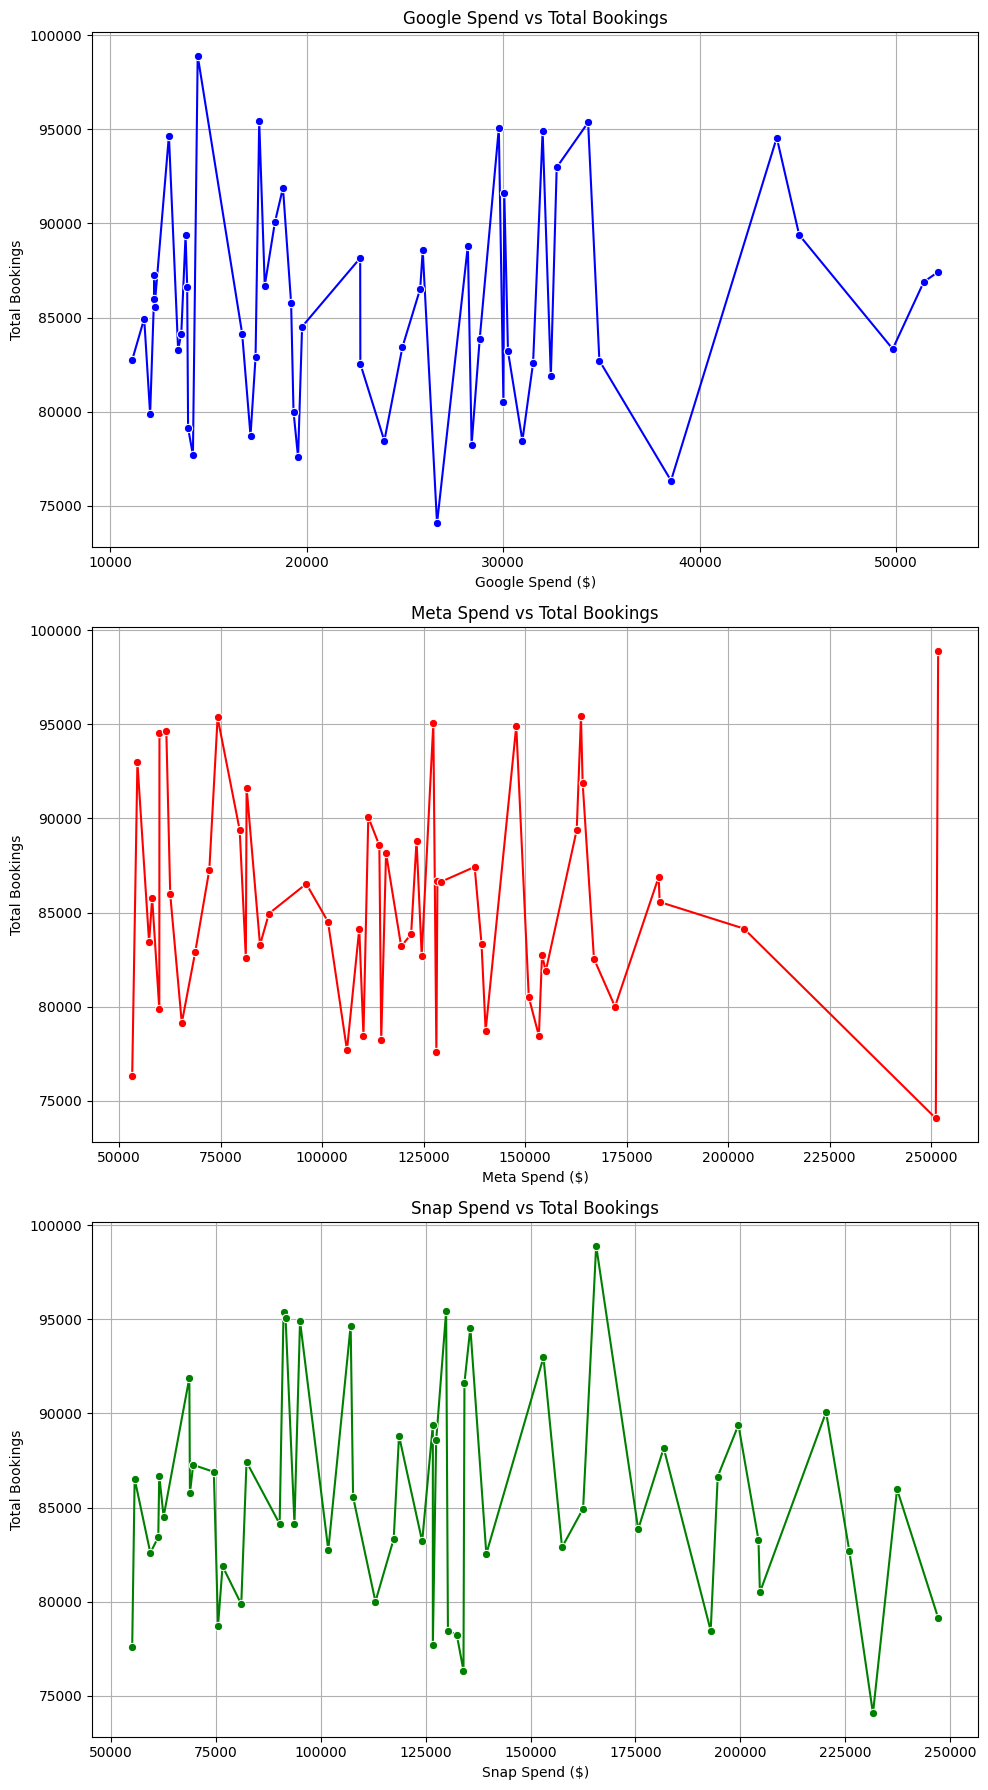

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_mmm["total_bookings"] = (
    df_mmm["Bookings (No VTC)_google"] +
    df_mmm["Bookings (No VTC)_meta"] +
    df_mmm["Bookings (No VTC)_snap"]
)

# Create a figure with 3 subplots (one per spend channel)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Plot for Google Spend vs Total Bookings
sns.lineplot(
    data=df_mmm,
    x="google_spend",
    y="total_bookings",
    marker="o",
    color="blue",
    ax=axes[0]
)
axes[0].set_title("Google Spend vs Total Bookings")
axes[0].set_xlabel("Google Spend ($)")
axes[0].set_ylabel("Total Bookings")
axes[0].grid(True)

# Plot for Meta Spend vs Total Bookings
sns.lineplot(
    data=df_mmm,
    x="meta_spend",
    y="total_bookings",
    marker="o",
    color="red",
    ax=axes[1]
)
axes[1].set_title("Meta Spend vs Total Bookings")
axes[1].set_xlabel("Meta Spend ($)")
axes[1].set_ylabel("Total Bookings")
axes[1].grid(True)

# Plot for Snap Spend vs Total Bookings
sns.lineplot(
    data=df_mmm,
    x="snap_spend",
    y="total_bookings",
    marker="o",
    color="green",
    ax=axes[2]
)
axes[2].set_title("Snap Spend vs Total Bookings")
axes[2].set_xlabel("Snap Spend ($)")
axes[2].set_ylabel("Total Bookings")
axes[2].grid(True)

plt.tight_layout()  # Adjusts subplot params so that subplots fit in the figure area.
plt.show()


# Create the Dependent Variable: Cost per Booking



```
# This is formatted as code
```

# New Section

# 1st Model - Bayesian Statstics Model MMMM

In [ ]:
## Step 1: Adstock Function
import numpy as np

def adstock_transform(spend_array, alpha=0.5):

    adstocked = np.zeros_like(spend_array, dtype=float)
    carryover = 0.0
    for t in range(len(spend_array)):
        carryover = spend_array[t] + alpha * carryover
        adstocked[t] = carryover
    return adstocked


In [ ]:
## Step 2: Saturation (Hill) Function
def hill_saturation(x_array, hill_a=1.0, hill_b=1.0, hill_c=1.0):

    x_powered = np.power(x_array, hill_b)
    saturated = hill_a * ( x_powered / (hill_c + x_powered) )chat
    return saturated


In [ ]:
## Step 1: Define or import your adstock and hill_saturation functions
def adstock_transform(spend_array, alpha=0.5):
    ad_array = []
    carryover = 0.0
    for val in spend_array:
        carryover = val + alpha * carryover
        ad_array.append(carryover)
    return ad_array

def hill_saturation(x_array, hill_a=1.0, hill_b=1.0, hill_c=1.0):
    import numpy as np
    x_powered = np.power(x_array, hill_b)
    return hill_a * (x_powered / (hill_c + x_powered))

## Step 2: Choose alpha (decay) and Hill parameters
ALPHA_GOOGLE = 0.5
ALPHA_META   = 0.5
ALPHA_SNAP   = 0.5

HILL_A = 1.0
HILL_B = 1.0
HILL_C = 1.0

## Step 3: Transform Google, Meta, Snap spend with Adstock + Saturation

# 1) Adstock transform each platform's spend
df_mmm["adstock_google"] = adstock_transform(df_mmm["google_spend"].values, alpha=ALPHA_GOOGLE)
df_mmm["adstock_meta"]   = adstock_transform(df_mmm["meta_spend"].values,   alpha=ALPHA_META)
df_mmm["adstock_snap"]   = adstock_transform(df_mmm["snap_spend"].values,   alpha=ALPHA_SNAP)

# 2) Then apply Hill saturation to each adstock series
df_mmm["sat_google"] = hill_saturation(df_mmm["adstock_google"].values, HILL_A, HILL_B, HILL_C)
df_mmm["sat_meta"]   = hill_saturation(df_mmm["adstock_meta"].values,   HILL_A, HILL_B, HILL_C)
df_mmm["sat_snap"]   = hill_saturation(df_mmm["adstock_snap"].values,   HILL_A, HILL_B, HILL_C)


In [ ]:
## Step 4: Inspect transformations
df_mmm[["google_spend", "adstock_google", "sat_google"]].head(10)
df_mmm[["meta_spend", "adstock_meta", "sat_meta"]].head(10)
df_mmm[["snap_spend", "adstock_snap", "sat_snap"]].head(10)


,snap_spend,adstock_snap,sat_snap
0,225946.92,225946.920000,0.999996
1,126716.43,239689.890000,0.999996
2,61520.02,181364.965000,0.999994
3,127506.93,218189.412500,0.999995
4,59396.87,168491.576250,0.999994
5,74526.64,158772.428125,0.999994
6,199540.63,278926.844062,0.999996
7,69605.95,209069.372031,0.999995
8,95067.70,199602.386016,0.999995
9,107709.37,207510.563008,0.999995


In [ ]:
## Step 5: Bayesian Regression with PyMC using df_mmm
import pymc as pm
import arviz as az

# Define the dependent variable from df_mmm
y_data = df_mmm["total_bookings"].values

# Define the predictors (saturated spend variables) from df_mmm
google_sat = df_mmm["sat_google"].values
meta_sat   = df_mmm["sat_meta"].values
snap_sat   = df_mmm["sat_snap"].values

with pm.Model() as mmm_saturation_model:
    # Priors on coefficients
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_google = pm.Normal("beta_google", mu=0, sigma=10)
    beta_meta   = pm.Normal("beta_meta",   mu=0, sigma=10)
    beta_snap   = pm.Normal("beta_snap",   mu=0, sigma=10)

    # Expected value: linear combination of the saturated variables
    mu = beta_0 + beta_google * google_sat + beta_meta * meta_sat + beta_snap * snap_sat

    # Noise term for the likelihood
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Likelihood: modeling cost per booking as normally distributed around mu
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=y_data)


In [ ]:
## Step 6: MCMC Sampling and Results
with mmm_saturation_model:
    trace = pm.sample(draws=2000, tune=1000, target_accept=0.9, random_seed=42)


Sampling chain 0, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1% 0:00:18 / 0:00:00

Sampling chain 0, 0 divergences ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2% 0:01:02 / 0:00:01

Output()

Sampling chain 1, 0 divergences ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  20% 0:00:23 / 0:00:05

In [ ]:
# Summarize posterior
az.summary(trace, var_names=["beta_0", "beta_google", "beta_meta", "beta_snap", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,71.809,9.949,54.204,91.747,0.136,0.097,5329.0,2942.0,1.0
beta_google,71.883,9.846,53.327,89.585,0.138,0.098,5087.0,2589.0,1.0
beta_meta,72.021,10.040,54.403,91.738,0.154,0.109,4253.0,2570.0,1.0
beta_snap,72.060,10.069,53.892,90.918,0.147,0.105,4709.0,3146.0,1.0
sigma,2481.541,5.052,2472.035,2491.018,0.070,0.050,5155.0,2922.0,1.0


In [ ]:
df_mmm.columns

Index(['index', 'week of', 'impression_google', 'impression_meta',
       'impression_snap', 'clicks_google', 'clicks_meta', 'clicks_snap',
       'google_spend', 'meta_spend', 'snap_spend', 'Bookings (No VTC)_google',
       'Bookings (No VTC)_meta', 'Bookings (No VTC)_snap',
       'cost_per_booking_google', 'cost_per_booking_meta',
       'cost_per_booking_snap', 'total_bookings', 'adstock_google',
       'adstock_meta', 'adstock_snap', 'sat_google', 'sat_meta', 'sat_snap'],
      dtype='object')

## New Section 2nd Model - StatsModel Simple Linear Regression MMM

# Regression Plot

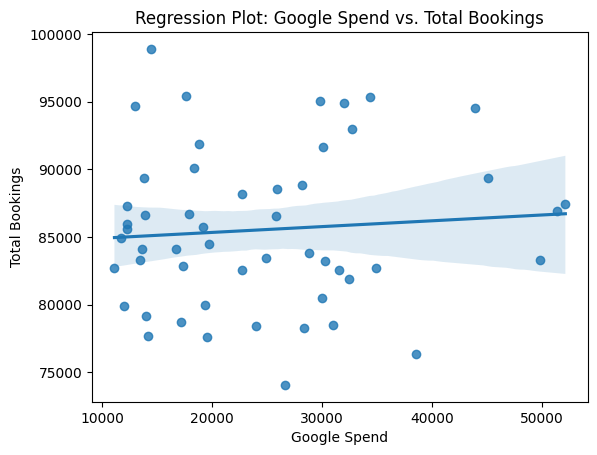

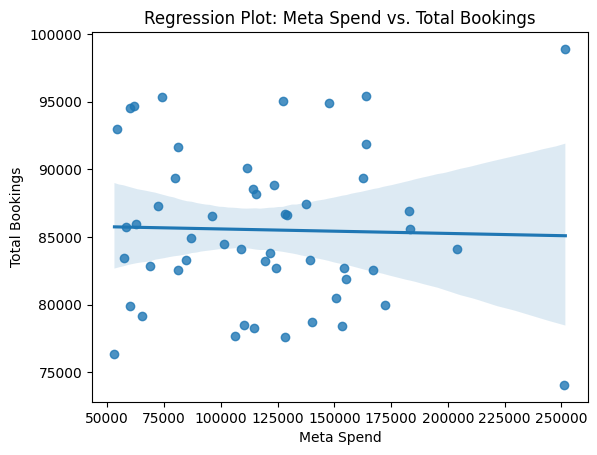

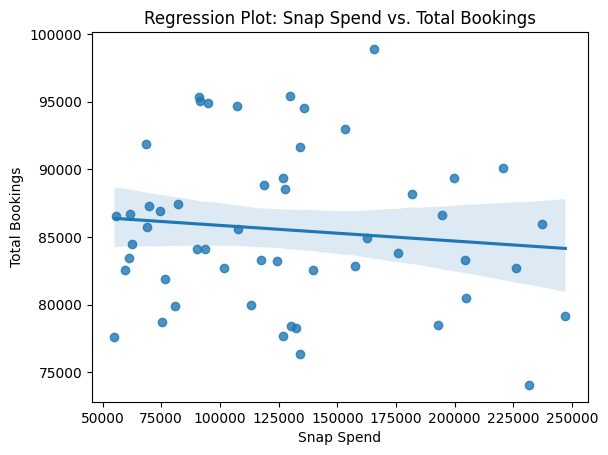

In [ ]:
# Regression plot for Google spend vs. total bookings
sns.regplot(x='google_spend', y='total_bookings', data=df_mmm)
plt.title('Regression Plot: Google Spend vs. Total Bookings')
plt.xlabel('Google Spend')
plt.ylabel('Total Bookings')
plt.show()

# Regression plot for Meta spend vs. total bookings
sns.regplot(x='meta_spend', y='total_bookings', data=df_mmm)
plt.title('Regression Plot: Meta Spend vs. Total Bookings')
plt.xlabel('Meta Spend')
plt.ylabel('Total Bookings')
plt.show()

# Regression plot for Snap spend vs. total bookings
sns.regplot(x='snap_spend', y='total_bookings', data=df_mmm)
plt.title('Regression Plot: Snap Spend vs. Total Bookings')
plt.xlabel('Snap Spend')
plt.ylabel('Total Bookings')
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Drop any rows that have missing values in the relevant columns
df_clean = df_mmm.dropna(subset=['google_spend', 'meta_spend', 'snap_spend', 'total_bookings'])

# Define the independent variables (spends) and the dependent variable (total_bookings)
X = df_clean[['google_spend', 'meta_spend', 'snap_spend']]
X = sm.add_constant(X)  # add an intercept term
y = df_clean['total_bookings']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         total_bookings   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.3014
Date:                Fri, 14 Feb 2025   Prob (F-statistic):              0.824
Time:                        04:32:59   Log-Likelihood:                -523.00
No. Observations:                  52   AIC:                             1054.
Df Residuals:                      48   BIC:                             1062.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8.633e+04   3389.031     25.472   